# Problem Session 5
## The Simpsons and Bicycles I

In the first of two time series based problem sessions we focus on some of the basics of time series forecasting. In particular, we will do some exploratory data analysis, test your understanding of data split adjustments and build a couple of first step models for two time series.

The problems in this notebook will cover the content covered in our `Time Series Forecasting` lectures including:
- `What are Time Series and Forecasting`,
- `Adjustments for Time Series Data`,
- `Time and Dates in Python` and
- `Baseline Forecasts`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style

set_style("whitegrid")

### The Simpsons

##### 1. Introducing the data

The first data set you will work with is the IMDB ratings of every Simpsons episode (as of May 6, 2022). If you recall, you pulled this data in `Problem Session 1` using the `Cinemagoer` package. For this notebook you will load a saved version of the data.

Load `simpsons_imdb.csv` from the `Data` folder, look at the first five observations.

In [2]:
simpsons = pd.read_csv("../Data/simpsons_imdb.csv")

In [3]:
simpsons.head()

,season,episode,title,imdb_rating
0,1,1,Simpsons Roasting on an Open Fire,8.101235
1,1,2,Bart the Genius,7.701235
2,1,3,Homer's Odyssey,7.301235
3,1,4,There's No Disgrace Like Home,7.701235
4,1,5,Bart the General,7.901235


Here are descriptions for the columns of this data set:
- `season` is the season of the Simpsons to which the episode belongs,
- `episode` gives the number of that episode with respect to when it aired in its season,
- `title` gives the name of the episode,
- `imdb_rating` is the average rating of the episode among IMDB's users.

##### 2. Train test split

We will use half a season as our forecast's horizon. Make a train test split that sets aside the last season (roughly two of our horizons) as a test set and uses the rest as a training set.

##### Sample Solution

In [4]:
simps_train = simpsons.loc[simpsons.season != 33].copy()
simps_test = simpsons.drop(simps_train.index)

##### 3. EDA

Plot the training data using a scatter plot.

Does this time series seem to exhibit a trend? Does this time series seem to exhibit seasonality? If it exhibits either do your best to describe what you see.

##### Sample Solution

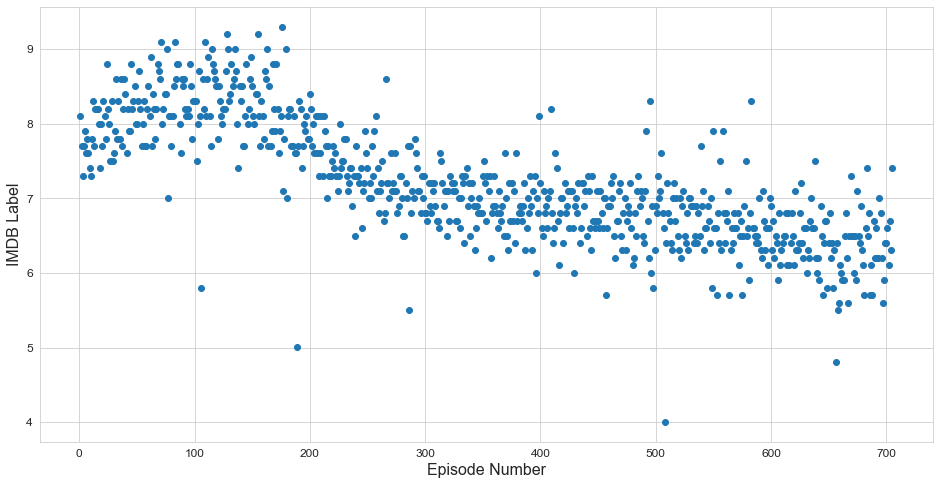

In [5]:
plt.figure(figsize=(16,8))

plt.scatter(range(1, len(simps_train)+1), simps_train.imdb_rating)

plt.xlabel("Episode Number", fontsize=16)
plt.ylabel("IMDB Label", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

This data does not seem to exhibit seasonality, but it does appear to exhibit a trend. While there is a clear upward trend over the first 100 episodes, there appears to be a negative trend over the remaining episodes.

##### 4. Choose baselines

Choose one or two baseline models that you could build on these data. Plot these models over the training observations.

##### Sample Solution

<b>Baseline 1</b>

The average model

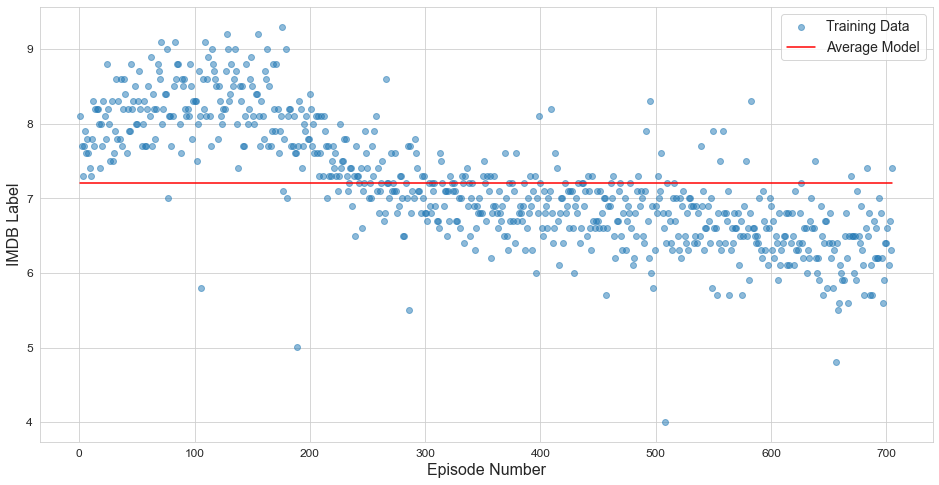

In [6]:
plt.figure(figsize=(16,8))

plt.scatter(range(1, len(simps_train)+1), 
            simps_train.imdb_rating,
            alpha=.5,
            label="Training Data")

plt.plot(range(1, len(simps_train)+1),
            simps_train.imdb_rating.mean()*np.ones(len(simps_train)),
            'r',
            label="Average Model")

plt.xlabel("Episode Number", fontsize=16)
plt.ylabel("IMDB Label", fontsize=16)

plt.legend(fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

<b>Baseline 2</b>

A trend model with an intercept.

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
slr = LinearRegression()

slr.fit(np.arange(1, len(simps_train)+1).reshape(-1,1), simps_train.imdb_rating.values)

LinearRegression()

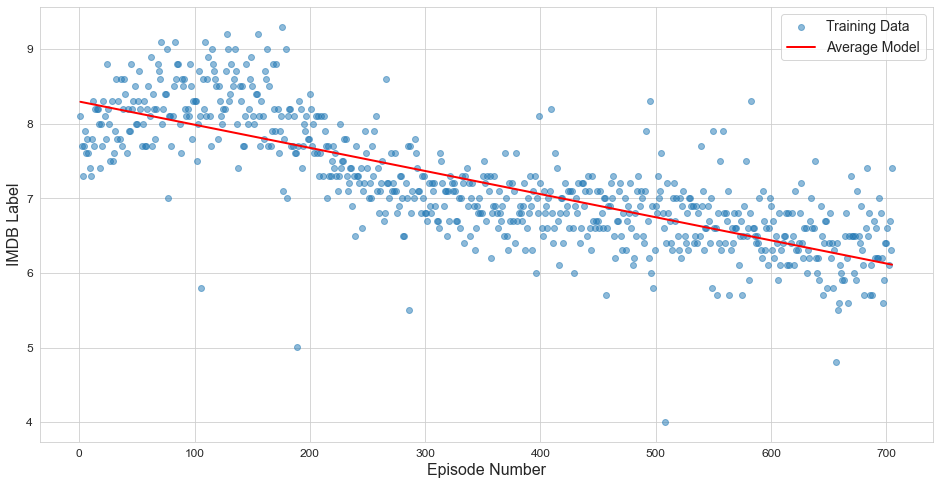

In [9]:
plt.figure(figsize=(16,8))

plt.scatter(range(1, len(simps_train)+1), 
            simps_train.imdb_rating,
            alpha=.5,
            label="Training Data")

plt.plot(range(1, len(simps_train)+1),
            slr.predict(np.arange(1, len(simps_train)+1).reshape(-1,1)),
            'r',
            linewidth=2,
            label="Average Model")

plt.xlabel("Episode Number", fontsize=16)
plt.ylabel("IMDB Label", fontsize=16)

plt.legend(fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

##### 5. Baseline CV Average MSE

Calculate the average cross-validation mean squared error for these two baseline models. Set up this cross-validation so that there are five splits.

##### Sample Solution

In [10]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [11]:
## 11 is roughly half a season
cv = TimeSeriesSplit(5, test_size=11)

In [12]:
mses = np.zeros((2, 5))

j = 0
for train_index, test_index in cv.split(simps_train):
    simps_tt = simps_train.loc[train_index]
    simps_ho = simps_train.loc[test_index]
    
    ## baseline 1
    pred1 = simps_tt.imdb_rating.mean()*np.ones(len(simps_ho))
    
    mses[0,j] = mean_squared_error(simps_ho.imdb_rating.values, pred1)
    
    ## baseline 2
    slr = LinearRegression()

    slr.fit(np.arange(1, len(simps_tt)+1).reshape(-1,1), simps_tt.imdb_rating.values)
    
    pred2 = slr.predict(np.arange(len(simps_tt)+1, len(simps_tt) + len(simps_ho) + 1).reshape(-1,1))
    
    mses[1,j] = mean_squared_error(simps_ho.imdb_rating.values, pred2)
    j = j + 1

In [13]:
print("The mean CV MSE for the average baseline is", 
          np.round(np.mean(mses[0,:]), 3))
print("The mean CV MSE for the trend baseline is",
          np.round(np.mean(mses[1,:]), 3))

The mean CV MSE for the average baseline is 1.121
The mean CV MSE for the trend baseline is 0.285


We will return to these baseline performances in `Problem Session 6`.

### Google trends "bike" interest

The second data set you will work with in this problem session is a time series collected using <a href="https://trends.google.com/trends/?geo=US">Google Trends</a>.

<img src="bike.png" width="20%"></img>


##### 1. Load the data

Load the data stored in `bike_google_trends.csv` stored in the `Data` folder.

Look at the first five observations.

<i>Hint: you may want to turn the `Month` column into a datetime</i>.

In [14]:
bike = pd.read_csv("../Data/bike_google_trends.csv", parse_dates=['Month'])

In [15]:
bike.head()

,Month,bike_interest
0,2004-01-01,28
1,2004-02-01,29
2,2004-03-01,38
3,2004-04-01,47
4,2004-05-01,59


- The `Month` column of this data set gives the month and year that the interest was measured. 
- The `bike_interest` column of this data set gives the level of interest (in percent) based on Google search engine searches for the term "bikes", scaled so that the month with greatest interest has a value of $100\%$ while every other month is the percent of the maximum interest recorded.

##### 2. Identifying stakeholders

One thing you may need to get more practice with is identifying the <i>stakeholders</i> for a particular problem. The stakeholders are the people who are most interested in your problem and the outcome of your solution.

Thinking about this can help you frame your project goals and focus your thinking to provide a solution that most suits the stakeholders' wants/needs.

For this question, take some time to think about what kinds of people may most be interested in forecasting interest in bikes. Why might they be interested? How could this forecast best help them?

##### Sample Solution

One group that may be interested in forecasting bike interest are bike shop owners. In particular, someone starting a new bike shop could perhaps be the most interested, since they would not have any of their own sales or service data with which to make projections.

An accurate forecast of interest could be parlayed into business planning decisions. Increases in interest could be correlated to increases in sales or increases in bike maintenance requests. This could suggest when bike shops should anticipate needing a larger number of bikes in stock or more maintenance workers on staff.

##### 3. Train test split

Make a train test split in the data. Set aside May 2021 to May 2022 as a test set.

<i>Hint: the `datetime` module could be useful.</i>

##### Sample Solution

In [16]:
from datetime import datetime, timedelta

In [17]:
bike_train = bike.loc[bike.Month <= datetime(2021, 5, 1)].copy()
bike_test = bike.drop(bike_train.index).copy()

##### 4. EDA 1

Plot the training data.

Does this time series appear to exhibit a trend or seasonality?

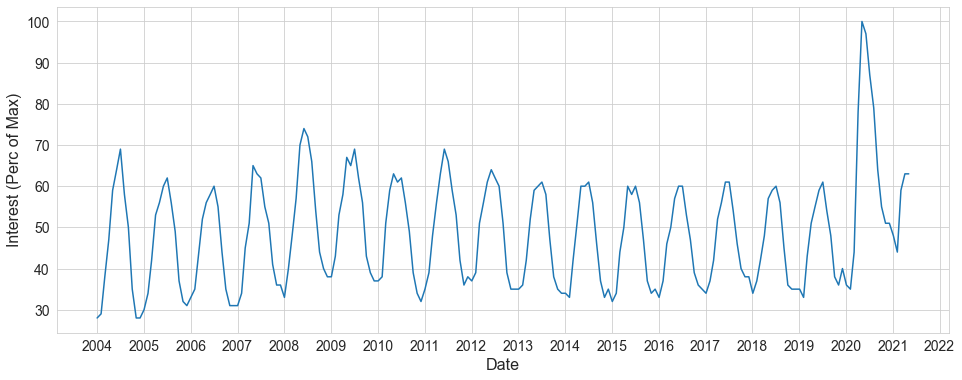

In [18]:
plt.figure(figsize=(16,6))

plt.plot(bike_train.Month, 
         bike_train.bike_interest)

plt.ylabel("Interest (Perc of Max)", fontsize=16)
plt.xlabel("Date", fontsize=16)

plt.xticks([datetime(2004,1,1) + timedelta(days=365*i) for i in range(19)],
              range(2004, 2023),
              fontsize=14)

plt.yticks(fontsize=14)

plt.show()

This data appears to exhibit seasonality. The exact length of a season appears to be one year, or $12$ months.

##### 4. EDA II

One way to explore the number of time steps in a given season is to plot scatter plots of the time series against itself at given <i>lags</i>. Such plots place the time series on the horizontal axis and the time series at $\ell$ steps into the future on the vertical axis. Seasonal data should exhibit a high correlation between itself and lags at multiples of the season length.

Make such scatter plots for lag values from $\ell=1$ to $\ell=25$. Also calculate the correlation between the time series and its lagged series for each value of $\ell$ (this is known as the <i>autocorrelation</i>). Using this information how long would you say a season is?

##### Sample Solution

In [19]:
def make_lag_plot(lag):
    x = bike_train.bike_interest.values[:-lag]
    y = bike_train.bike_interest.values[lag:]
    
    plt.figure(figsize=(6,6))
    
    plt.scatter(x, y, alpha=.7)
    plt.plot([0,100], [0,100], 'k--')
    
    plt.title("Lag = " + str(lag), fontsize=16)
    
    plt.show()
    
    return np.corrcoef(x,y)[0,1]

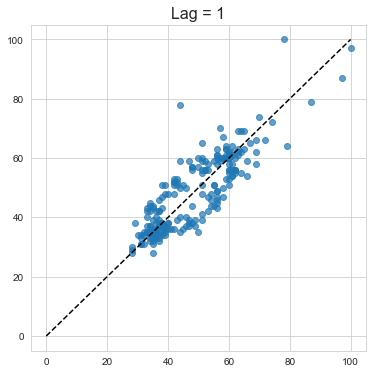

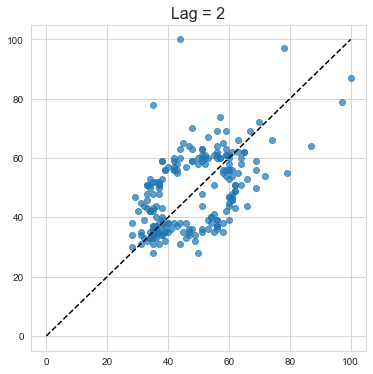

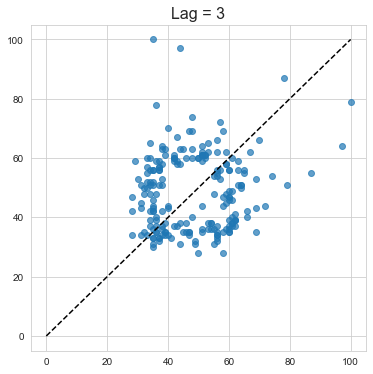

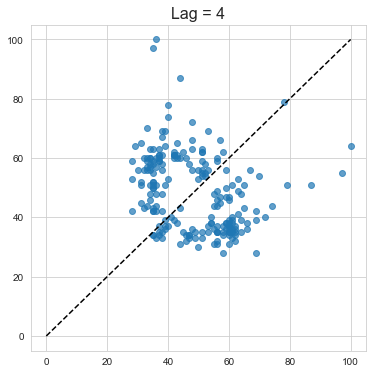

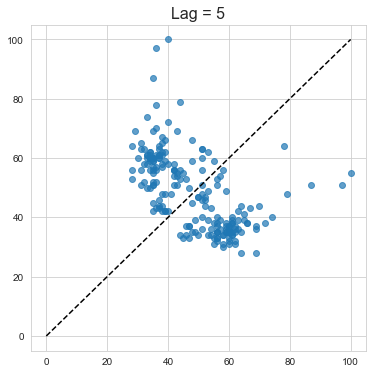

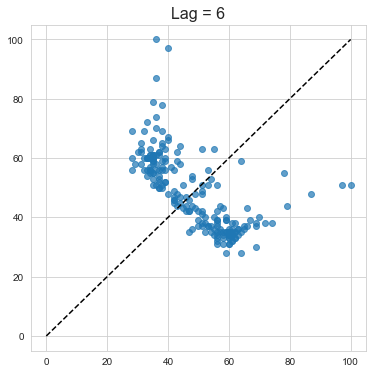

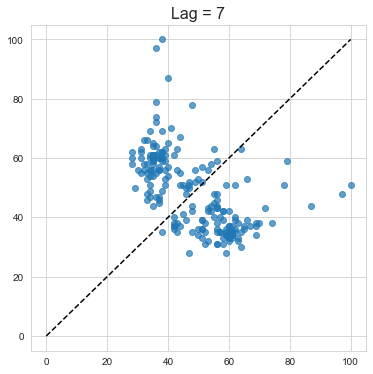

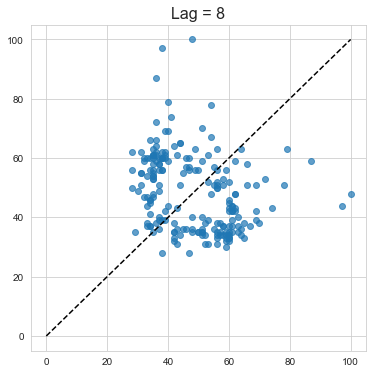

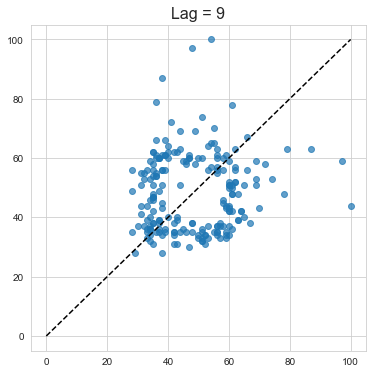

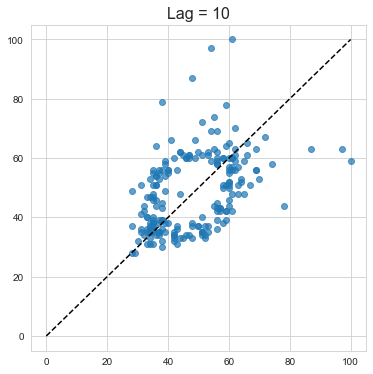

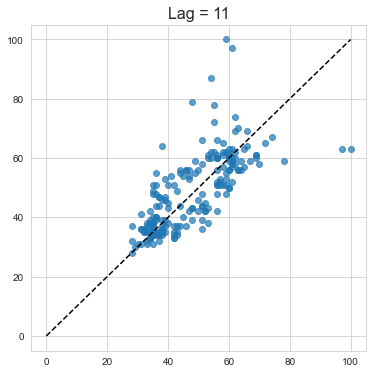

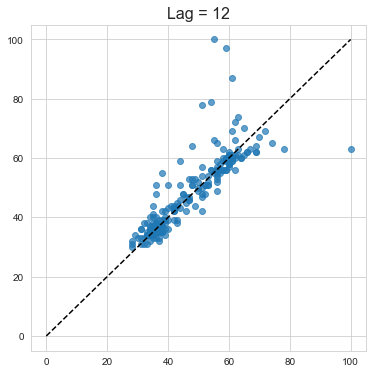

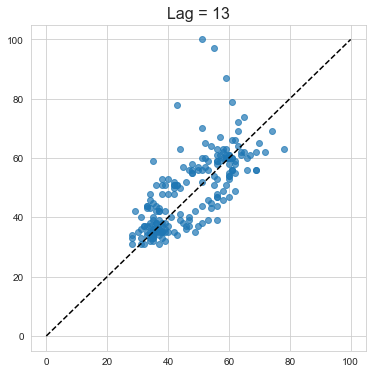

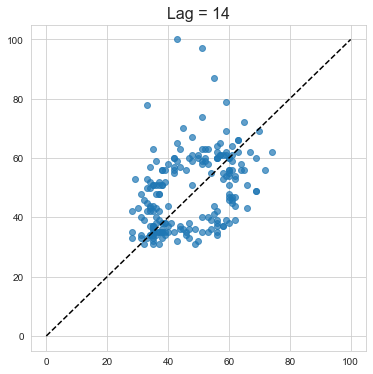

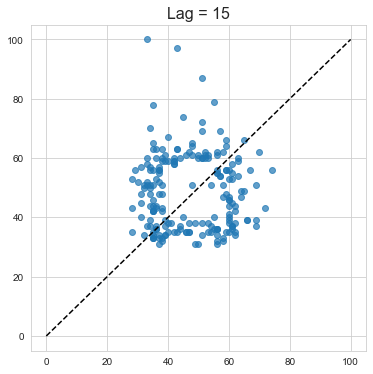

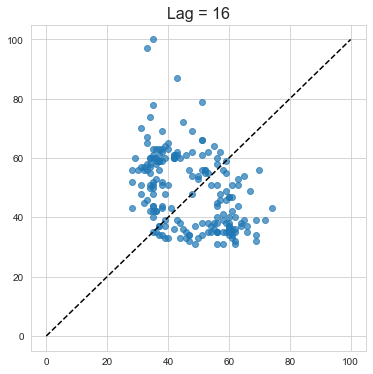

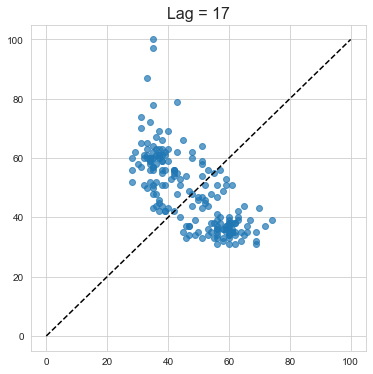

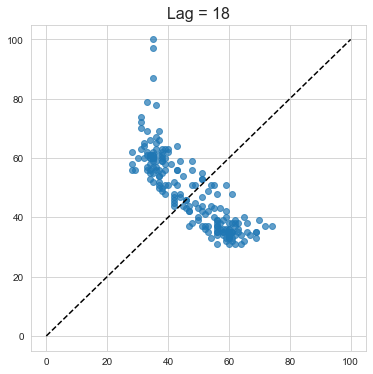

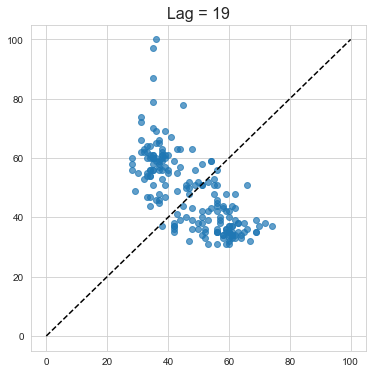

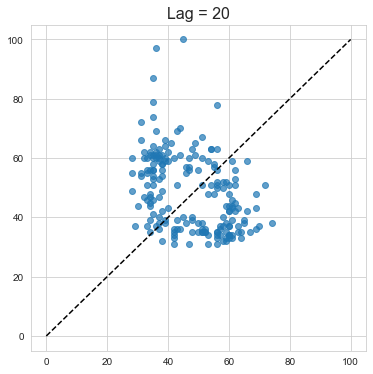

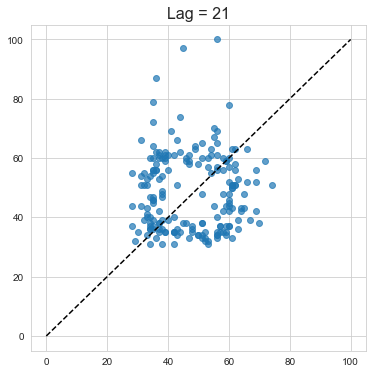

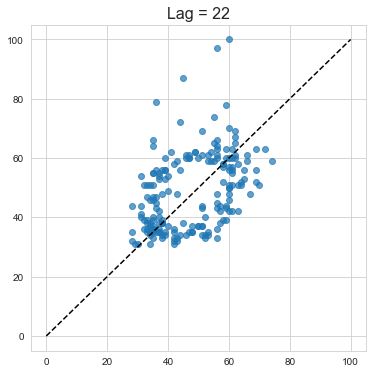

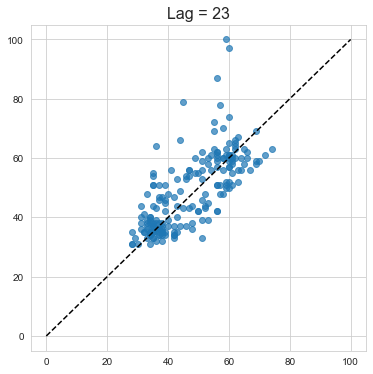

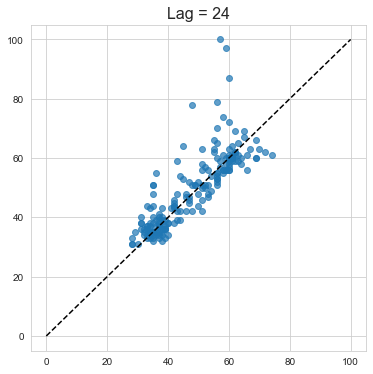

In [20]:
corr_coefs = []

for lag in range(1,25):
    corr_coefs.append(make_lag_plot(lag))

In [21]:
pd.DataFrame({'lag':range(1,25),
                 'autocorrelation':corr_coefs})

,lag,autocorrelation
0,1,0.854070
1,2,0.520227
2,3,0.102539
3,4,-0.284773
4,5,-0.567836
5,6,-0.671464
6,7,-0.565006
7,8,-0.288658
8,9,0.074588
9,10,0.438266


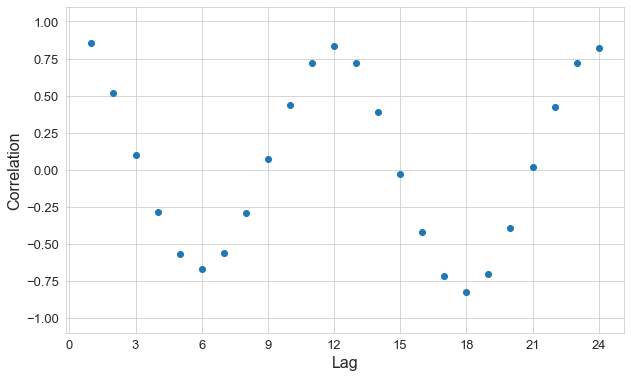

In [22]:
plt.figure(figsize=(10,6))

plt.scatter(range(1,25), corr_coefs)

plt.xlabel("Lag", fontsize=16)
plt.ylabel("Correlation", fontsize=16)

plt.xticks(range(0,25,3), fontsize=13)
plt.yticks(fontsize=13)

plt.ylim([-1.1,1.1])

plt.show()

I would say that a season lasts 12 time steps, corresponding to one year.

##### 5. Baselines

Select two baseline forecasts for these data.

Create a validation set of June 2020 to May 2021 and plot your baseline predictions alongside the actual validation data.

##### Sample Solution

##### 1. Seasonal Average Forecast

In [23]:
def get_month(date):
    return date.month

bike_train['month_of_date'] = bike_train['Month'].apply(get_month)

In [24]:
bike_tt = bike_train.loc[bike_train.Month < datetime(2020,6,1)].copy()
bike_val = bike_train.drop(bike_tt.index).copy()

avg_month_dict = {}

for month in range(1,13):
    avg_month_dict[month] = bike_tt.loc[bike_tt.month_of_date==month].bike_interest.mean()
    
val_forecast = []

for i in bike_val.index:
    val_forecast.append(avg_month_dict[bike_val.month_of_date[i]])

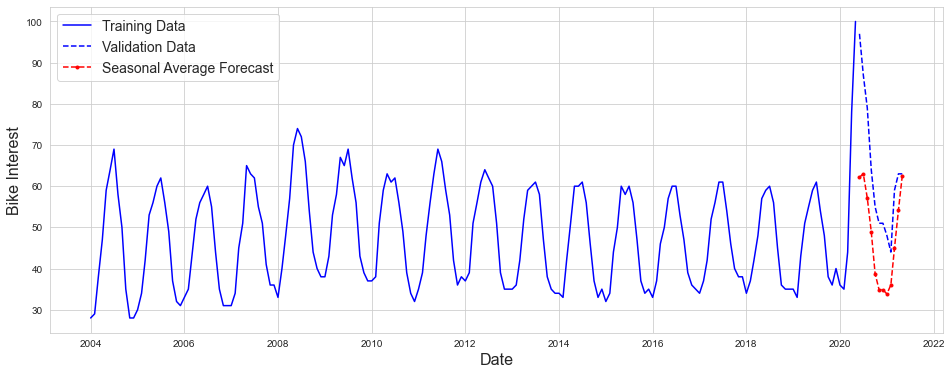

In [25]:
plt.figure(figsize=(16, 6))

plt.plot(bike_tt.Month, 
            bike_tt.bike_interest,
            'b',
            label = "Training Data")

plt.plot(bike_val.Month,
            bike_val.bike_interest,
            'b--',
            label = "Validation Data")

plt.plot(bike_val.Month,
            val_forecast,
            'r--.',
            label="Seasonal Average Forecast")

plt.legend(fontsize=14)

plt.ylabel("Bike Interest", fontsize=16)
plt.xlabel("Date", fontsize=16)

plt.show()

##### 2. Seasonal Naive Forecast

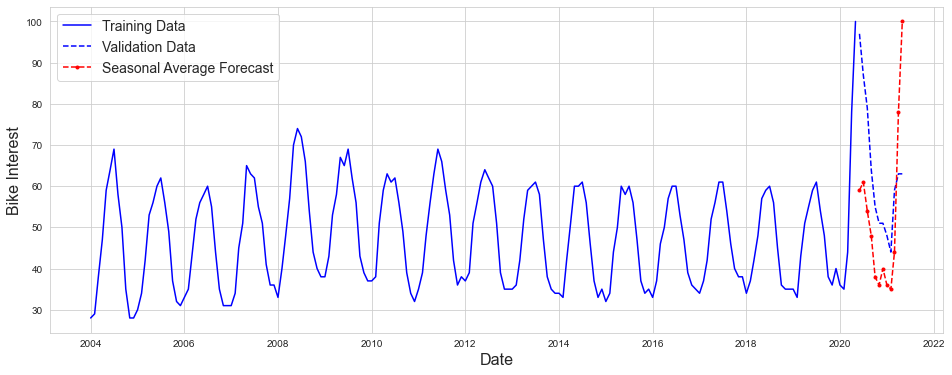

In [26]:
plt.figure(figsize=(16, 6))

plt.plot(bike_tt.Month, 
            bike_tt.bike_interest,
            'b',
            label = "Training Data")

plt.plot(bike_val.Month,
            bike_val.bike_interest,
            'b--',
            label = "Validation Data")

plt.plot(bike_val.Month,
            bike_tt.loc[bike_tt.Month>=datetime(2019,6,1)].bike_interest,
            'r--.',
            label="Seasonal Average Forecast")

plt.legend(fontsize=14)

plt.ylabel("Bike Interest", fontsize=16)
plt.xlabel("Date", fontsize=16)

plt.show()

##### 6. Evaluating baselines

Visually speaking, how does it look like your two baselines do on the validation set? Does the observed interest level seem consistent with the rest of the time series? Do your best to explain your answer.

In light of your answer, should we include these data in our forecasting process? Why or Why not?

##### Sample Solution

Bike interest soared in the United States in 2020.

This was related to the onset of the COVID-19 pandemic, <a href="https://www.bbc.com/future/bespoke/made-on-earth/the-great-bicycle-boom-of-2020.html">https://www.bbc.com/future/bespoke/made-on-earth/the-great-bicycle-boom-of-2020.html</a>. At the time, outdoor physical activities were seen as safe, and many indoor forms of physical recreation were temporarily closed. This actually led to a big shortage in bicycles, <a href="https://www.census.gov/library/stories/2021/06/consumers-turn-to-biking-for-safe-fun-exercise-during-pandemic.html">https://www.census.gov/library/stories/2021/06/consumers-turn-to-biking-for-safe-fun-exercise-during-pandemic.html</a> and other at home workout equipment.

We will return to these data in the time series `Practice Problems` notebooks.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2022.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)